In [2]:
from __future__ import annotations


from collections import defaultdict #allows access to keys 
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch #draw shapes
import numpy as np
import seaborn as sna
from tqdm import tqdm #progress bar

import gymnasium as gym

In [3]:
env = gym.make('Blackjack-v1', natural=False, sab=True)

In [4]:
# reset the environment to get the first observation
done=False
observation,info=env.reset()

In [5]:
print(observation)

(9, 7, 0)


In [6]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1
observation, reward, terminated, truncated, info = env.step(action)

env.step() function returns :
- next_state: This is the observation that the agent will receive after taking the action.
- reward: This is the reward that the agent will receive after taking the action.
- terminated: This is a boolean variable that indicates whether or not the environment has terminated.
- truncated: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
- info: This is a dictionary that might contain additional information about the environment.

# Build a Q-learning agent to solve Blackjack-v1!

In [7]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []
        
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

# Training Of the agent

In [8]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [9]:
from IPython.display import clear_output
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs,info=env.reset()
    done=False
    clear_output()
    
    # Play one episode
    while not done:
        action=agent.get_action(obs)
        next_obs,reward,terminated,truncated,info=env.step(action)
        
        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [01:02<00:00, 1597.87it/s]


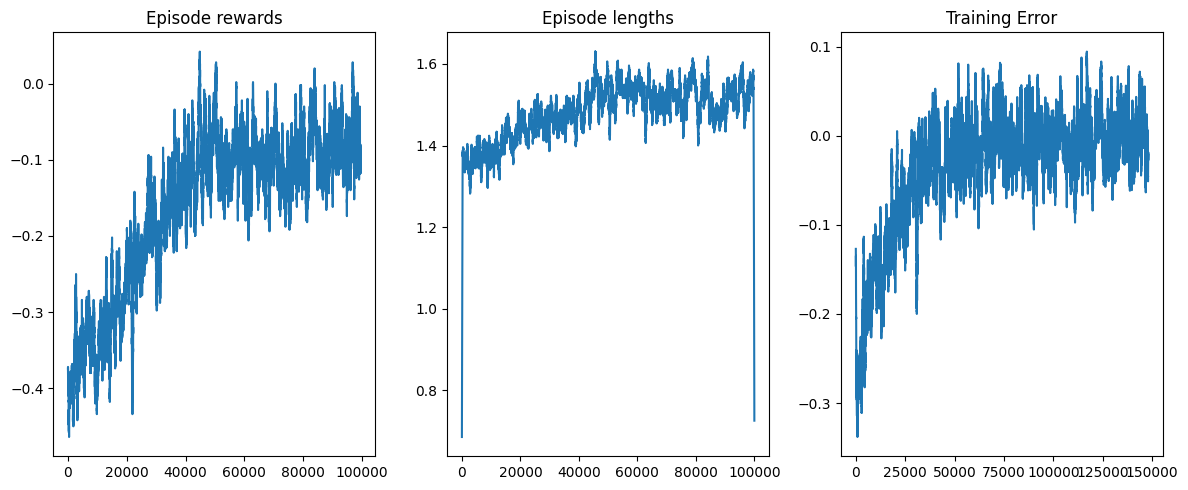

In [11]:
rolling_length=500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average=(
    np.convolve(
        np.array(env.return_queue).flatten(),np.ones(rolling_length),mode="valid")/rolling_length
)

axs[0].plot(range(len(reward_moving_average)),reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## **Visualising the policy**